In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
import bayesnet as bn

np.random.seed(1234)

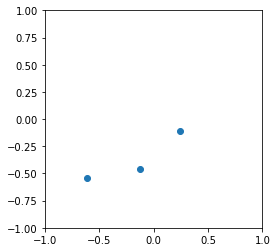

In [2]:
x_train = np.random.uniform(-1, 1, 3)
y_train = 0.5 * x_train - 0.3 + np.random.normal(scale=0.1, size=x_train.shape)
X_train = PolynomialFeatures(degree=1).fit_transform(x_train[:, None])

plt.scatter(x_train, y_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

In [3]:
class AnalyticalBayesianRegressor(object):
    
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta
        
    def fit(self, X, y):
        self.w_cov = np.linalg.inv(self.alpha * np.eye(X.shape[1]) + self.beta * X.T @ X)
        self.w_mean = self.beta * self.w_cov @ X.T @ y
        
    def predict(self, X):
        y_mean = X @ self.w_mean
        y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=-1)
        return y_mean, y_var

In [4]:
analytical_model = AnalyticalBayesianRegressor(alpha=1., beta=100.)
analytical_model.fit(X_train, y_train)

In [5]:
class BayesianRegressor(bn.Network):
    
    def __init__(self, w=np.zeros(2)):
        super().__init__(w=w)

    def __call__(self, x, y=None):
        self.pw = bn.random.MultivariateGaussian(np.zeros(2), np.eye(2), data=self.w)
        self.py = bn.random.MultivariateGaussian((x * self.w).sum(axis=-1), 0.01 * np.eye(len(x)), data=y)
        if y is None:
            return self.py.mu.value

In [6]:
model = BayesianRegressor()
optimizer = bn.optimizer.Adam(model, 0.1)
optimizer.set_decay(0.9, 100)
for _ in range(1000):
    model.clear()
    model(X_train, y_train)
    log_posterior = model.log_pdf()
    log_posterior.backward()
    optimizer.update()

In [7]:
sample = bn.sampler.metropolis(
    BayesianRegressor(model.w.value),
    (X_train, y_train),
    1000,
    downsample=10,
    w=bn.random.Gaussian(np.zeros(2), 0.1)
)

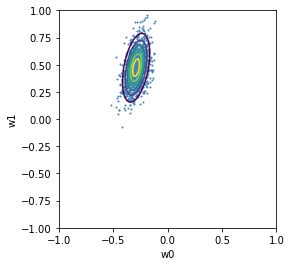

In [8]:
w0, w1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
w_grid = np.array([w0, w1]).transpose(1, 2, 0)
plt.contour(w0, w1, multivariate_normal.pdf(w_grid, mean=analytical_model.w_mean, cov=analytical_model.w_cov))
w_sample = np.asarray(sample["w"])
plt.scatter(w_sample[:, 0], w_sample[:, 1], c="steelblue", s=1)
plt.xlabel("w0")
plt.ylabel("w1")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal")

In [9]:
sample = bn.sampler.hmc(
    BayesianRegressor(model.w.value),
    (X_train, y_train),
    sample_size=1000,
    step_size=1e-2,
    n_step=10
)

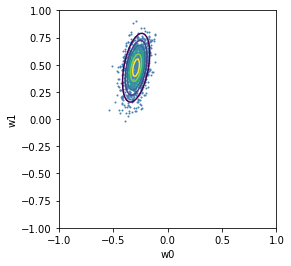

In [10]:
w0, w1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
w_grid = np.array([w0, w1]).transpose(1, 2, 0)
plt.contour(w0, w1, multivariate_normal.pdf(w_grid, mean=analytical_model.w_mean, cov=analytical_model.w_cov))
w_sample = np.asarray(sample["w"])
plt.scatter(w_sample[:, 0], w_sample[:, 1], c="steelblue", s=1)
plt.xlabel("w0")
plt.ylabel("w1")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal")